<a href="https://colab.research.google.com/github/arnabbiswas66/multimodal-fake-news-classifier/blob/main/Twitter_multimodal_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -q -U "tensorflow-text==2.11.*"

In [4]:
!pip install -q tf-models-official==2.11.0

In [92]:
from tensorflow.python.platform.tf_logging import warn
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import os
import re
import shutil
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
tf.get_logger().setLevel('ERROR')
import warnings

warnings.filterwarnings('ignore')

In [93]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [94]:
def get_df(file):
    return pd.read_table(file,sep = '\t', lineterminator='\n')

In [127]:
train_df = get_df('/content/drive/MyDrive/multimodal-news/mediaeval2015/devset/tweets.txt')
test_df = get_df('/content/drive/MyDrive/multimodal-news/mediaeval2015/testset/tweets.txt')

In [128]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14277 entries, 0 to 14276
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     14277 non-null  int64 
 1   tweetText   14277 non-null  object
 2   userId      14277 non-null  int64 
 3   imageId(s)  14277 non-null  object
 4   username    14277 non-null  object
 5   timestamp   14277 non-null  object
 6   label       14277 non-null  object
dtypes: int64(2), object(5)
memory usage: 780.9+ KB


In [129]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     3755 non-null   int64 
 1   tweetText   3755 non-null   object
 2   userId      3755 non-null   int64 
 3   imageId(s)  3755 non-null   object
 4   username    3755 non-null   object
 5   timestamp   3755 non-null   object
 6   label       3755 non-null   object
dtypes: int64(2), object(5)
memory usage: 205.5+ KB


## Flatten the image folder structure for both devset and testset for ease of processing

In [60]:
def flatten(directory, targetDir):
    if not os.path.exists(targetDir):
        os.makedirs(targetDir)
    for dirpath, _, filenames in os.walk(directory, topdown=False):
        for filename in filenames:
            i = 0
            source = os.path.join(dirpath, filename)
            target = os.path.join(targetDir, filename)

            shutil.move(source, target)

    print("Moved", directory, "to", targetDir)

In [12]:
# Devset
SRC_DIR = '/content/drive/MyDrive/multimodal-news/mediaeval2015/devset/Medieval2015_DevSet_Images/'
TARGET_DIR = '/content/drive/MyDrive/multimodal-news/mediaeval2015/devset/images/'

flatten(SRC_DIR, TARGET_DIR)

Moved /content/drive/MyDrive/multimodal-news/mediaeval2015/devset/Medieval2015_DevSet_Images/ to /content/drive/MyDrive/multimodal-news/mediaeval2015/devset/images/


In [12]:
# Testset
SRC_DIR = '/content/drive/MyDrive/multimodal-news/mediaeval2015/testset/TestSetImages/'
TARGET_DIR = '/content/drive/MyDrive/multimodal-news/mediaeval2015/testset/images/'

flatten(SRC_DIR, TARGET_DIR)

Moved /content/drive/MyDrive/multimodal-news/mediaeval2015/testset/TestSetImages/ to /content/drive/MyDrive/multimodal-news/mediaeval2015/testset/images/


## Initial Preprocessing of data

In [130]:
# TODO consider both the images and not just the first one
def return_first_image(row):
    return row['imageId(s)'].split(',')[0].strip()

In [131]:
train_df['first_image_id'] = train_df.apply (lambda row: return_first_image(row),axis=1)
test_df['first_image_id'] = test_df.apply (lambda row: return_first_image(row),axis=1)

In [132]:
from os import listdir

In [133]:

images_train_dataset = [i for i in train_df['first_image_id'].tolist()]
images_train_folder = [i.split('.')[0].strip() for i in listdir('/content/drive/MyDrive/multimodal-news/mediaeval2015/devset/images/')]
images_train_not_available = set(images_train_dataset)-set(images_train_folder)
images_train_not_available

{'boston_fake_35', 'sandyB_real_4', 'sandyB_real_6', 'sochi_fake_1fake'}

In [134]:
images_test_dataset = [i.split(',')[0].strip() for i in test_df['first_image_id'].tolist()]
images_test_folder = [i.split('.')[0].strip() for i in listdir('/content/drive/MyDrive/multimodal-news/mediaeval2015/testset/images/')]
images_test_not_available = set(images_test_dataset)-set(images_test_folder)
images_test_not_available

{'eclipse_video_01', 'syrianboy_1', 'varoufakis_1'}

In [135]:
print(train_df.shape, test_df.shape)

(14277, 8) (3755, 8)


In [136]:
train_df = train_df[~train_df['first_image_id'].isin(images_train_not_available)]

In [137]:
test_df = test_df[~test_df['first_image_id'].isin(images_test_not_available)]
print(train_df.shape, test_df.shape)

(14258, 8) (1923, 8)


In [138]:
train_text = train_df['tweetText'].tolist()
test_text = test_df['tweetText'].tolist()

train_images = [i for i in train_df['first_image_id'].tolist()]
test_images = [i.split(',')[0].strip() for i in test_df['first_image_id'].tolist()]

trainY = train_df['label'].tolist()
trainY = [1 if i=='real' else 0 for i in trainY]

testY = test_df['label'].tolist()
testY = [1 if i=='real' else 0 for i in testY]

In [139]:
len(train_text),len(train_images),len(trainY),len(test_text),len(test_images),len(testY)

(14258, 14258, 14258, 1923, 1923, 1923)

In [140]:
# calculate the maximum document length
def max_length(lines):
    return max([len(s.split()) for s in lines])

maximum length: 901


(array([   0.,    4.,  327.,  532.,  755.,  760.,  843.,  791.,  904.,
        2534., 2379.,  775., 1462., 1113., 1047.,   17.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 12., 15., 16.,
        18., 20., 25., 30.]),
 <BarContainer object of 16 artists>)

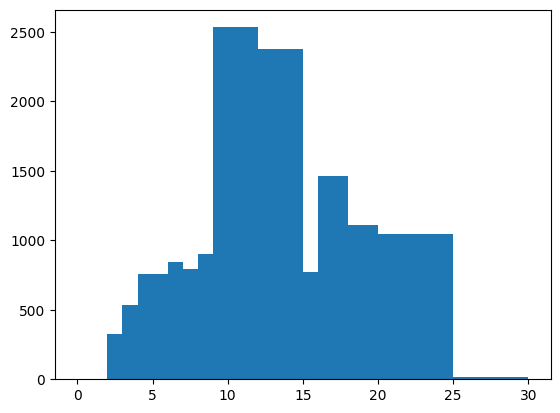

In [141]:
print("maximum length:", max_length(train_text))
plt.hist([len(s.split()) for s in train_text],bins=[0,1,2,3,4,5,6,7,8,9,12,15,16,18,20,25,30])

In [142]:
l=[len(s.split()) for s in train_text]
count=0.0
for i in l:
    if i>25:
        count+=1
print(count,len(l))
print(count/len(l))

17.0 14258
0.0011923130873895357


In [143]:
max_seq_length=25

# Visualize random tweets

In [144]:
import glob

In [145]:
DEV_IMAGE_DIR = '/content/drive/MyDrive/multimodal-news/mediaeval2015/devset/images/'
TEST_IMAGE_DIR = '/content/drive/MyDrive/multimodal-news/mediaeval2015/testset/images/'

In [146]:
def find_image_from_name_in_dir(image_name, dir):
  for name in glob.glob(dir+'/'+image_name+'.*'):
    return name

In [147]:
def visualise(index, text_df, image_df, train=True):
  path = DEV_IMAGE_DIR if train else TEST_IMAGE_DIR
  text = text_df[index]
  image_path = find_image_from_name_in_dir(image_df[index],path)
  image = plt.imread(image_path)
  plt.subplot(1, 1, 1)
  plt.title(text)
  plt.imshow(image)


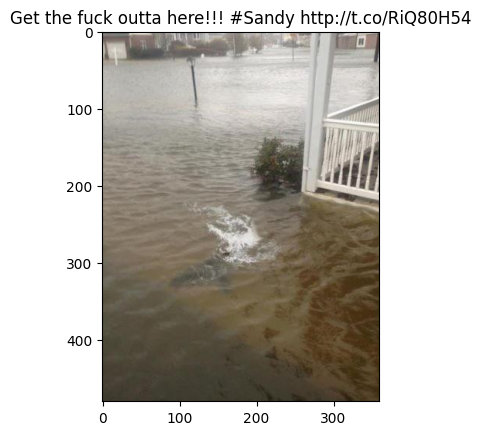

In [148]:
import random
indx = random.randint(0, 3000)
visualise(indx, train_text, train_images)

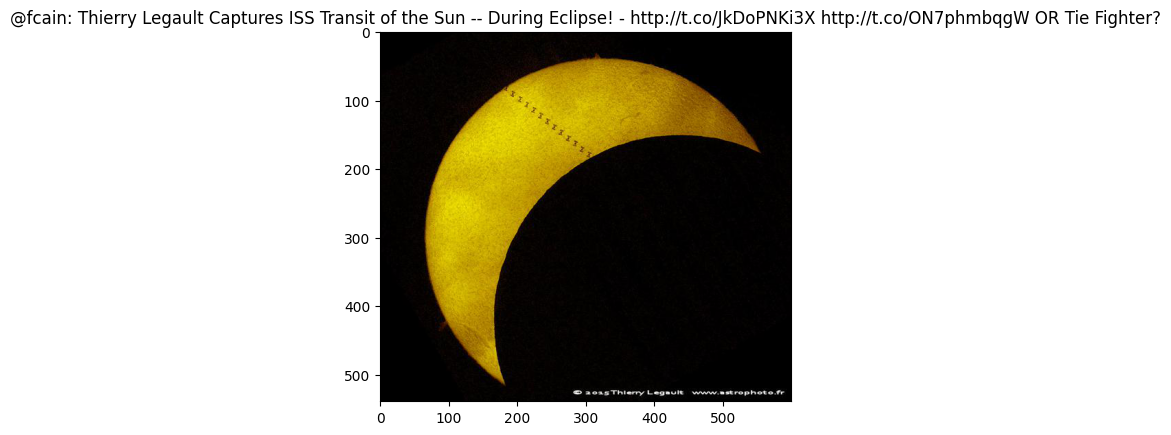

In [149]:
indx = random.randint(0, 1000)
visualise(indx, test_text, test_images, False)

## Start of modeling

In [150]:
# Alternate dataframes for modeling
train_df_model = train_df[['tweetText', 'first_image_id', 'label']]
train_df_model['label'] = train_df_model['label'].apply(lambda x: 1 if x=='real' else 0)
train_df_model['image_1'] = train_df_model['first_image_id'].apply(lambda x: find_image_from_name_in_dir(x, DEV_IMAGE_DIR))
train_df_model = train_df_model.drop(['first_image_id'], axis=1)
train_df_model.head(5)

,tweetText,label,image_1
0,¿Se acuerdan de la película: “El día después d...,0,/content/drive/MyDrive/multimodal-news/mediaev...
1,@milenagimon: Miren a Sandy en NY! Tremenda i...,0,/content/drive/MyDrive/multimodal-news/mediaev...
2,"Buena la foto del Huracán Sandy, me recuerda a...",0,/content/drive/MyDrive/multimodal-news/mediaev...
3,Scary shit #hurricane #NY http://t.co/e4JLBUfH,0,/content/drive/MyDrive/multimodal-news/mediaev...
4,My fave place in the world #nyc #hurricane #sa...,0,/content/drive/MyDrive/multimodal-news/mediaev...


In [151]:
# Check to make sure all the first_image_id are tied with a path
train_df_model[train_df_model['image_1'].isnull()]

,tweetText,label,image_1


In [152]:
train_df_model['label'].value_counts()

0    9353
1    4905
Name: label, dtype: int64

In [153]:
test_df_model = test_df[['tweetText', 'first_image_id', 'label']]
test_df_model['label'] = test_df_model['label'].apply(lambda x: 1 if x=='real' else 0)
test_df_model['image_1'] = test_df_model['first_image_id'].apply(lambda x: find_image_from_name_in_dir(x, TEST_IMAGE_DIR))
test_df_model = test_df_model.drop(['first_image_id'], axis=1)
test_df_model.head(10)

,tweetText,label,image_1
0,kereeen RT @Shyman33: Eclipse from ISS.... htt...,0,/content/drive/MyDrive/multimodal-news/mediaev...
1,Absolutely beautiful! RT @Shyman33: Eclipse fr...,0,/content/drive/MyDrive/multimodal-news/mediaev...
2,“@Shyman33: Eclipse from ISS.... http://t.co/C...,0,/content/drive/MyDrive/multimodal-news/mediaev...
3,Eclipse from ISS.... http://t.co/En87OtvsU6,0,/content/drive/MyDrive/multimodal-news/mediaev...
4,@ebonfigli: Éclipse vue de l'ISS... Autre chos...,0,/content/drive/MyDrive/multimodal-news/mediaev...
5,“@ebonfigli: Éclipse vue de l'ISS... Autre cho...,0,/content/drive/MyDrive/multimodal-news/mediaev...
6,Éclipse vue de l'ISS... Autre chose... http://...,0,/content/drive/MyDrive/multimodal-news/mediaev...
7,@ebonfigli: Éclipse vue de l'ISS... Autre chos...,0,/content/drive/MyDrive/multimodal-news/mediaev...
8,Dit dus \0/ RT “@News_Executive: The Solar ecl...,0,/content/drive/MyDrive/multimodal-news/mediaev...
9,Photo: The Solar eclipse as seen from the Inte...,0,/content/drive/MyDrive/multimodal-news/mediaev...


In [154]:
# Check to make sure all the first_image_id are tied with a path
test_df_model[test_df_model['image_1'].isnull()]

,tweetText,label,image_1


In [155]:
test_df_model['label'].value_counts()

1    1207
0     716
Name: label, dtype: int64

# Data input pipeline

In [156]:
# Define TF Hub paths to the BERT encoder and its preprocessor
bert_model_path = (
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1"
)
bert_preprocess_path = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [157]:
import numpy as np

In [158]:
def make_bert_preprocessing_model(sentence_features, seq_length=128):
    """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: A list with the names of string-valued features.
    seq_length: An integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
        for ft in sentence_features
    ]

    # Tokenize the text to word pieces.
    bert_preprocess = hub.load(bert_preprocess_path)
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name="tokenizer")
    segments = [tokenizer(s) for s in input_segments]

    # Optional: Trim segments in a smart way to fit seq_length.
    # Simple cases (like this example) can skip this step and let
    # the next step apply a default truncation to approximately equal lengths.
    truncated_segments = segments

    # Pack inputs. The details (start/end token ids, dict of output tensors)
    # are model-dependent, so this gets loaded from the SavedModel.
    packer = hub.KerasLayer(
        bert_preprocess.bert_pack_inputs,
        arguments=dict(seq_length=seq_length),
        name="packer",
    )
    model_inputs = packer(truncated_segments)
    return keras.Model(input_segments, model_inputs)


In [159]:
bert_preprocess_model = make_bert_preprocessing_model(["text_1"])
bert_preprocess_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_1 (InputLayer)         [(None,)]                 0         
                                                                 
 tokenizer (KerasLayer)      (None, None, None)        0         
                                                                 
 packer (KerasLayer)         {'input_type_ids': (None  0         
                             , 128),                             
                              'input_word_ids': (None            
                             , 128),                             
                              'input_mask': (None, 12            
                             8)}                                 
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________

In [160]:
idx = np.random.choice(len(train_df_model))
row = train_df.iloc[idx]
sample_text_1, sample_text_2 = row["tweetText"], row["tweetText"]
print(f"Text 1: {sample_text_1}")
print(f"Text 2: {sample_text_2}")

test_text = [np.array([sample_text_1])]
text_preprocessed = bert_preprocess_model(test_text)

print("Keys           : ", list(text_preprocessed.keys()))
print("Shape Word Ids : ", text_preprocessed["input_word_ids"].shape)
print("Word Ids       : ", text_preprocessed["input_word_ids"][0, :16])
print("Shape Mask     : ", text_preprocessed["input_mask"].shape)
print("Input Mask     : ", text_preprocessed["input_mask"][0, :16])
print("Shape Type Ids : ", text_preprocessed["input_type_ids"].shape)
print("Type Ids       : ", text_preprocessed["input_type_ids"][0, :16])


Text 1: #SANDY IMPACT: Ground Zero http://t.co/qGbk7voa (via @BuzzFeedAndrew) (attn: @ShafaqHasan)
Text 2: #SANDY IMPACT: Ground Zero http://t.co/qGbk7voa (via @BuzzFeedAndrew) (attn: @ShafaqHasan)
Keys           :  ['input_type_ids', 'input_word_ids', 'input_mask']
Shape Word Ids :  (1, 128)
Word Ids       :  tf.Tensor(
[ 101 1001 7525 4254 1024 2598 5717 8299 1024 1013 1013 1056 1012 2522
 1013 1053], shape=(16,), dtype=int32)
Shape Mask     :  (1, 128)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 128)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


In [161]:
def dataframe_to_dataset(dataframe):
    columns = ['tweetText', 'image_1', 'label']
    dataframe = dataframe[columns].copy()
    labels = dataframe.pop("label")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

## Preprocessing utilities

In [162]:
resize = (128, 128)
bert_input_features = ["input_word_ids", "input_type_ids", "input_mask"]

In [163]:
def preprocess_image(image_path):
  extension = tf.strings.split(image_path,'.')[-1]
  image = tf.io.read_file(image_path)
  if extension == b"gif":
    image = tf.io.decode_image(image, 3, expand_animations=False)
  elif extension == b"png":
    image = tf.image.decode_png(image, 3)
  else:
    image = tf.image.decode_jpeg(image, 3)
  image = tf.image.resize(image, resize)
  return image

In [164]:
def preprocess_text(text_1):
  text_1 = tf.convert_to_tensor([text_1])
  output = bert_preprocess_model([text_1])
  output = {feature: tf.squeeze(output[feature]) for feature in bert_input_features}
  return output

In [165]:
def preprocess_text_and_image(sample):
  image_1 = preprocess_image(sample["image_1"])
  text = preprocess_text(sample["tweetText"])
  return {"image_1": image_1, "text": text}

In [166]:
batch_size = 32
auto = tf.data.AUTOTUNE

In [167]:
def prepare_dataset(dataframe, training=True):
  ds = dataframe_to_dataset(dataframe)
  if training:
      ds = ds.shuffle(len(train_df_model))
  ds = ds.map(lambda x, y: (preprocess_text_and_image(x), y)).cache()
  ds = ds.batch(batch_size).prefetch(auto)
  return ds

In [168]:
train_ds = prepare_dataset(train_df_model)
#validation_ds = prepare_dataset(val_df, False)
test_ds = prepare_dataset(test_df_model, False)

In [171]:
train_ds

<PrefetchDataset element_spec=({'image_1': TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), 'text': {'input_word_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None), 'input_type_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None), 'input_mask': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None)}}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>